# Machine Learning Engineer Nanodegree

## Capstone Project

## Predict Stock Prices

### Load Necessary Libraries

In [1]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from time import time
from IPython.display import display


from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers import LSTM, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from ipy_table import *

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
#Data path

SP500_file_path = 'data/SP500.csv'


IBM_file_path = 'data/IBM.csv'
MSFT_file_path = 'data/MSFT.csv'
WMT_file_path = 'data/WMT.csv'
PFE_file_path = 'data/PFE.csv'
MYL_file_path = 'data/MYL.csv'
XOM_file_path = 'data/XOM.csv'

AAPL_file_path = 'data/AAPL.csv'# AAPL row 167 cntains null
GOOG_file_path = 'data/GOOG.csv'



## Read Data

In [4]:


data_SP500 = pd.read_csv(SP500_file_path,index_col ='Date') 

data_IBM = pd.read_csv(IBM_file_path,index_col ='Date') 
data_MSFT = pd.read_csv(MSFT_file_path,index_col ='Date')
data_PFE = pd.read_csv(PFE_file_path,index_col ='Date') 
data_WMT = pd.read_csv(WMT_file_path,index_col ='Date')
data_XOM = pd.read_csv(XOM_file_path,index_col ='Date')
data_MYL = pd.read_csv(MYL_file_path,index_col ='Date')

data_AAPL = pd.read_csv(AAPL_file_path,index_col ='Date')
data_GOOG = pd.read_csv(GOOG_file_path,index_col ='Date')


In [5]:
data_SP500 = data_SP500[pd.notnull(data_SP500['Adj Close'])]

data_IBM = data_IBM[pd.notnull(data_IBM['Adj Close'])]
data_MSFT = data_MSFT[pd.notnull(data_MSFT['Adj Close'])]
data_PFE = data_PFE[pd.notnull(data_PFE['Adj Close'])]
data_WMT = data_WMT[pd.notnull(data_WMT['Adj Close'])]
data_XOM = data_XOM[pd.notnull(data_XOM['Adj Close'])]
data_MYL = data_MYL[pd.notnull(data_MYL['Adj Close'])]

data_AAPL = data_AAPL[pd.notnull(data_AAPL['Adj Close'])]
data_GOOG = data_GOOG[pd.notnull(data_GOOG['Adj Close'])]


In [6]:
data_SP500 = data_SP500.dropna()
data_IBM = data_IBM.dropna()
data_MSFT = data_MSFT.dropna()
data_PFE = data_PFE.dropna()
data_WMT = data_WMT.dropna()
data_XOM = data_XOM.dropna()
data_MYL = data_MYL.dropna()

data_AAPL = data_AAPL.dropna()
data_GOOG = data_GOOG.dropna()

In [7]:
data_SP500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,127.360001,129.979996,127.150002,129.229996,129.229996,39530000
1980-12-15,129.229996,131.330002,128.639999,129.449997,129.449997,39700000
1980-12-16,129.449997,131.220001,128.330002,130.600006,130.600006,41630000
1980-12-17,130.600006,133.589996,130.220001,132.889999,132.889999,50800000
1980-12-18,132.889999,135.899994,131.889999,133.000000,133.000000,69570000


In [8]:
data_SP500.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,2429.199951,2432.709961,2421.649902,2423.409912,2423.409912,3361590000
2017-07-03,2431.389893,2439.169922,2428.689941,2429.010010,2429.010010,1962290000
2017-07-05,2430.780029,2434.899902,2422.050049,2432.540039,2432.540039,3367220000
2017-07-06,2423.439941,2424.280029,2407.699951,2409.750000,2409.750000,3364520000
2017-07-07,2413.520020,2426.919922,2413.520020,2425.179932,2425.179932,2901330000


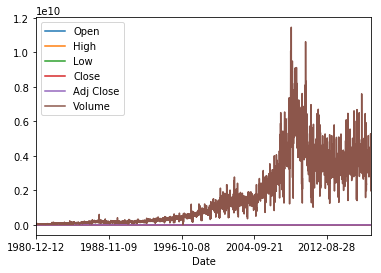

In [9]:
data_SP500.plot()

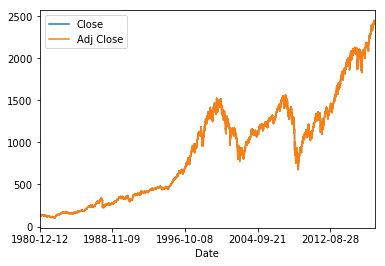

In [10]:
data_SP500[['Close','Adj Close']].plot()

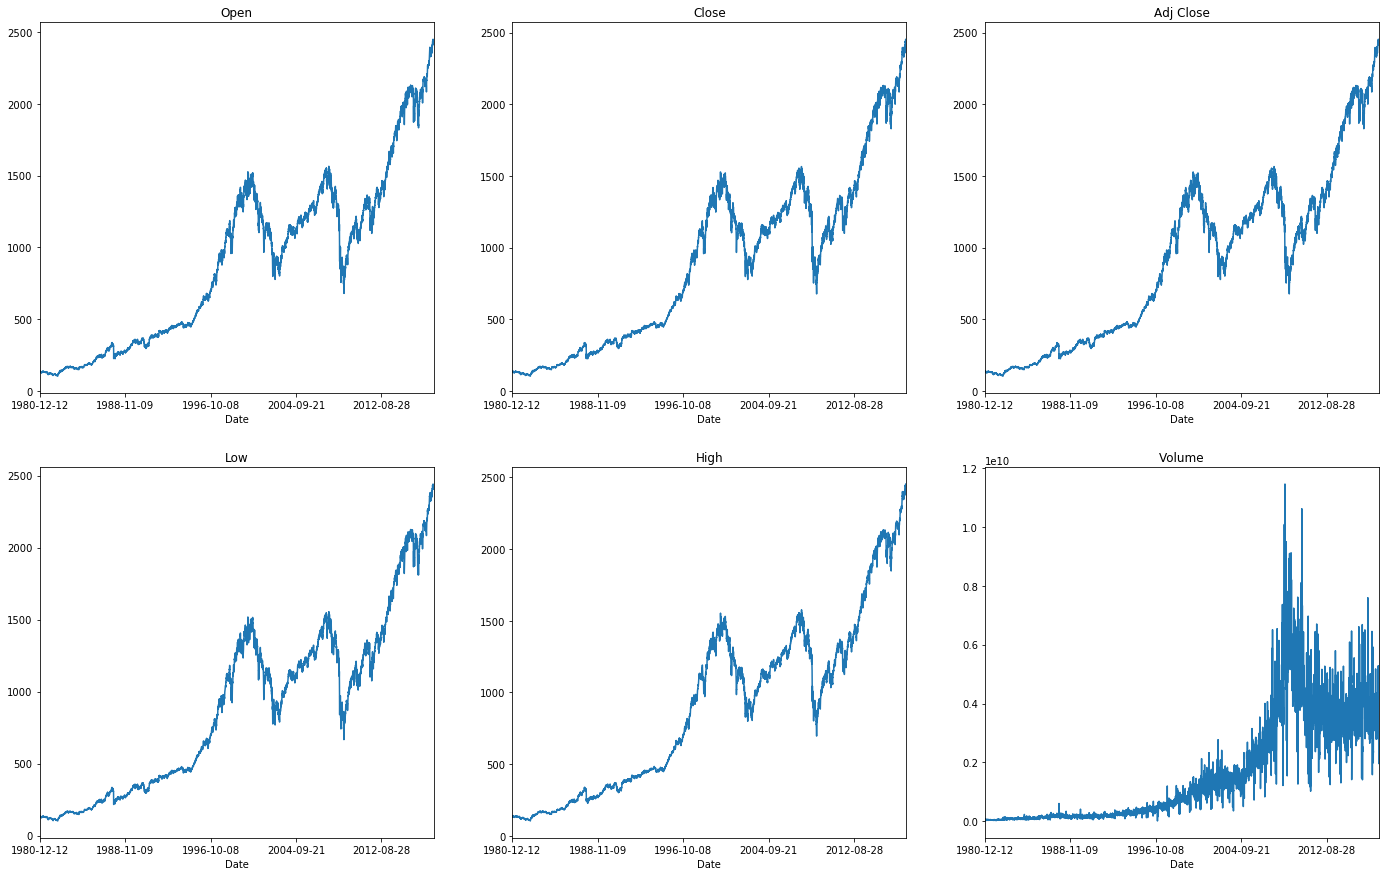

In [11]:
fig = plt.figure(figsize = (24,15))
ax1 = fig.add_subplot(2,3,1)
data_SP500['Open'].plot(ax=ax1, title = "Open")


ax2 = fig.add_subplot(2,3,2)
data_SP500['Close'].plot(ax=ax2, title = "Close")

ax3 = fig.add_subplot(2,3,3)
data_SP500['Adj Close'].plot(ax=ax3, title = "Adj Close")

#fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(2,3,4)
data_SP500['Low'].plot(ax=ax1, title = "Low")

ax2 = fig.add_subplot(2,3,5)
data_SP500['High'].plot(ax=ax2, title = "High")

ax3 = fig.add_subplot(2,3,6)
data_SP500['Volume'].plot(ax=ax3, title = "Volume")

#### From above graphs, it is clear that Open, Close, AdjClose, High and low follow almost same pattern, So I planned to take only Adj Close for prediction.  I calculated DailyReturn and used AdjClose as inputs also, but there was not much difference in the results. So to keep it simple and getting very impressive results with only AdjClose value, I rested with using only Adj Close for prediction.

#### Daily Return calculation and merging it with AdjClose is shown below to make 2 column input dataset.

### For this problem, I have tried to create a data dependency by making any day AdjClose value to be dependent upon previous days AdjClose values. I tried dependency windows to be 5, 10, 15, 50, 75 and 100 [ this means that current AdjClose value is dependent upon previous 5 or 10 or 15 or 50 or 75 or 100 days]. This dependency window will actually make the input features. So with a 5 days window, it means output AdjClose predicted value is dependent upon last 5 days.

### Below results will show that window 5 gave the best results.

In [12]:
data_SP500_AdjClose = data_SP500['Adj Close']
data_IBM_AdjClose = data_IBM['Adj Close']

data_MSFT_AdjClose = data_MSFT['Adj Close']
data_PFE_AdjClose = data_PFE['Adj Close']
data_WMT_AdjClose = data_WMT['Adj Close']
data_XOM_AdjClose = data_XOM['Adj Close']
data_MYL_AdjClose = data_MYL['Adj Close']

data_AAPL_AdjClose = data_AAPL['Adj Close']
data_GOOG_AdjClose = data_GOOG['Adj Close']

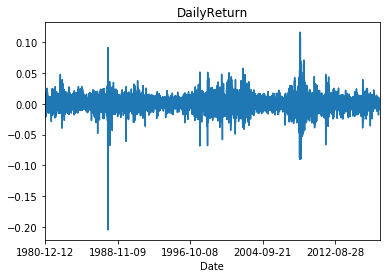

In [13]:
dailyReturn_SP500 = data_SP500_AdjClose/data_SP500_AdjClose.shift(1) - 1
dailyReturn_SP500[0] = 0.0
dailyReturn_SP500.plot(title='DailyReturn')

In [14]:
frames = [data_SP500_AdjClose, dailyReturn_SP500]
data_SP500_merged = pd.concat(frames,axis=1)
data_SP500_merged.columns = ['AdjClose', 'DailyReturn']

In [15]:
data_SP500_merged.head()

,AdjClose,DailyReturn
Date,,
1980-12-12,129.229996,0.000000
1980-12-15,129.449997,0.001702
1980-12-16,130.600006,0.008884
1980-12-17,132.889999,0.017534
1980-12-18,133.000000,0.000828


## Normalizing Data

#### Different scalars are used for each stock dataset so that these can be used later(if needed) to recover original values

In [16]:
from sklearn.preprocessing import MinMaxScaler
minmaxScaler_SP500 = MinMaxScaler((0,1))

values = data_SP500_AdjClose.values
index = data_SP500_AdjClose.index

values = minmaxScaler_SP500.fit_transform(values.reshape(-1,1))

normalized_data_SP500_AdjClose = pd.DataFrame(values, index = index)


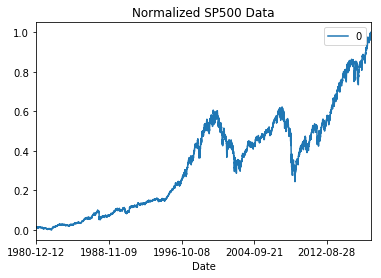

In [17]:
normalized_data_SP500_AdjClose.plot(title = "Normalized SP500 Data")

In [18]:
minmaxScaler_IBM = MinMaxScaler((0,1))

values = data_IBM_AdjClose.values
index = data_IBM_AdjClose.index

values = minmaxScaler_IBM.fit_transform(values.reshape(-1,1))

normalized_data_IBM_AdjClose = pd.DataFrame(values, index = index)

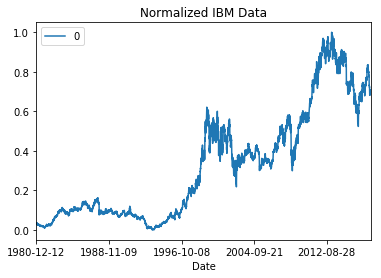

In [19]:
normalized_data_IBM_AdjClose.plot(title = "Normalized IBM Data")

In [20]:
minmaxScaler_MSFT = MinMaxScaler((0,1))

values = data_MSFT_AdjClose.values
index = data_MSFT_AdjClose.index

values = minmaxScaler_MSFT.fit_transform(values.reshape(-1,1))

normalized_data_MSFT_AdjClose = pd.DataFrame(values, index = index)

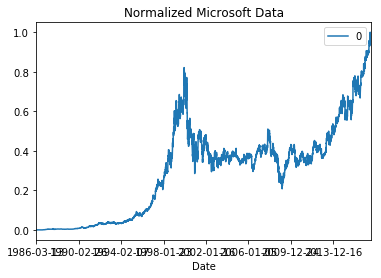

In [21]:
normalized_data_MSFT_AdjClose.plot(title = "Normalized Microsoft Data")

In [22]:
minmaxScaler_PFE = MinMaxScaler((0,1))

values = data_PFE_AdjClose.values
index = data_PFE_AdjClose.index

values = minmaxScaler_PFE.fit_transform(values.reshape(-1,1))

normalized_data_PFE_AdjClose = pd.DataFrame(values, index = index)

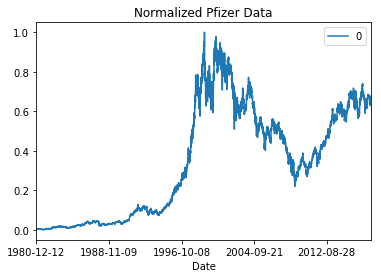

In [23]:
normalized_data_PFE_AdjClose.plot(title = "Normalized Pfizer Data")

In [24]:
minmaxScaler_WMT = MinMaxScaler((0,1))

values = data_WMT_AdjClose.values
index = data_WMT_AdjClose.index

values = minmaxScaler_WMT.fit_transform(values.reshape(-1,1))

normalized_data_WMT_AdjClose = pd.DataFrame(values, index = index)

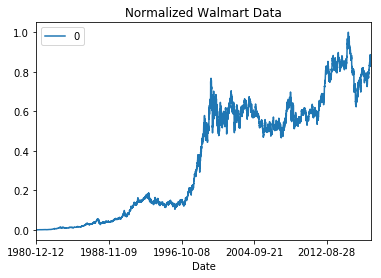

In [25]:
normalized_data_WMT_AdjClose.plot(title = "Normalized Walmart Data")

In [26]:
minmaxScaler_XOM = MinMaxScaler((0,1))

values = data_XOM_AdjClose.values
index = data_XOM_AdjClose.index

values = minmaxScaler_XOM.fit_transform(values.reshape(-1,1))

normalized_data_XOM_AdjClose = pd.DataFrame(values, index = index)

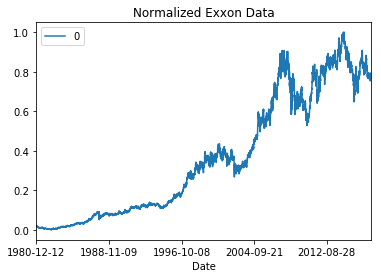

In [27]:
normalized_data_XOM_AdjClose.plot(title = "Normalized Exxon Data")

In [28]:
minmaxScaler_MYL = MinMaxScaler((0,1))

values = data_MYL_AdjClose.values
index = data_MYL_AdjClose.index

values = minmaxScaler_MYL.fit_transform(values.reshape(-1,1))

normalized_data_MYL_AdjClose = pd.DataFrame(values, index = index)

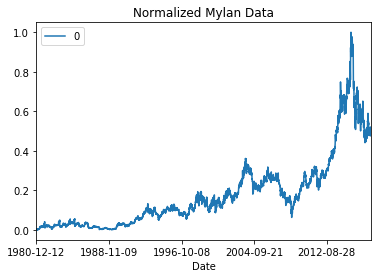

In [29]:
normalized_data_MYL_AdjClose.plot(title = "Normalized Mylan Data")

In [30]:
minmaxScaler_AAPL = MinMaxScaler((0,1))

values = data_AAPL_AdjClose.values
index = data_AAPL_AdjClose.index

values = minmaxScaler_AAPL.fit_transform(values.reshape(-1,1))

normalized_data_AAPL_AdjClose = pd.DataFrame(values, index = index)

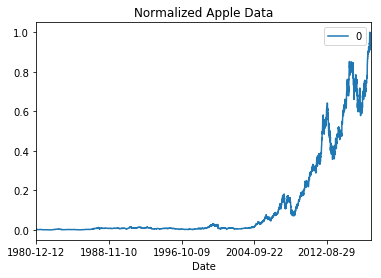

In [31]:
normalized_data_AAPL_AdjClose.plot(title = "Normalized Apple Data")

In [32]:
minmaxScaler_GOOG = MinMaxScaler((0,1))

values = data_GOOG_AdjClose.values
index = data_GOOG_AdjClose.index

values = minmaxScaler_GOOG.fit_transform(values.reshape(-1,1))

normalized_data_GOOG_AdjClose = pd.DataFrame(values, index = index)

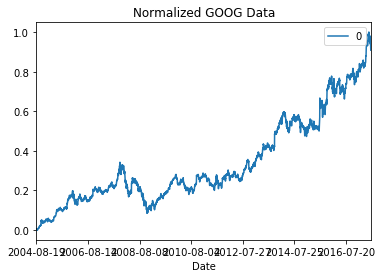

In [33]:
normalized_data_GOOG_AdjClose.plot(title = "Normalized GOOG Data")

## Tranform Data to window dependency supervised data

In [34]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    numWindows = len(series) - window_size
    
    for i in range(numWindows):
        lst = series[i:i + window_size]
        out = series[i + window_size]
        X.append(lst)        
        y.append(out)       
        
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y 

### Window Size

In [35]:
window_size = 5

In [36]:
dataset = normalized_data_SP500_AdjClose.values
X,y = window_transform_series(series=dataset,window_size = window_size)

### Split Data into Training, Validation and Test Datasets

In [37]:
train_test_split = int(np.ceil(8*len(y)/float(10)))  

X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

train_valid_split = train_test_split - (len(y) - train_test_split)

X_train = X[:train_valid_split,:]
y_train = y[:train_valid_split]

X_valid = X[train_valid_split:train_test_split,:]
y_valid = y[train_valid_split:train_test_split]


In [38]:
X_train_initial = X_train
X_valid_initial = X_valid
X_test_initial = X_test

In [39]:
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_valid = np.asarray(np.reshape(X_valid, (X_valid.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [40]:
def prepareSeriesData(inputData, window_size):
    
    X,y = window_transform_series(series=inputData,window_size = window_size)
    
    train_test_split = int(np.ceil(8*len(y)/float(10)))   

    X_test = X[train_test_split:,:]
    y_test = y[train_test_split:]

    train_valid_split = train_test_split - (len(y) - train_test_split)

    X_train = X[:train_valid_split,:]
    y_train = y[:train_valid_split]

    X_valid = X[train_valid_split:train_test_split,:]
    y_valid = y[train_valid_split:train_test_split]
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test


In [41]:
X_train_IBM, y_train_IBM, X_valid_IBM, y_valid_IBM, X_test_IBM, y_test_IBM = prepareSeriesData(normalized_data_IBM_AdjClose.values, window_size)
X_train_MSFT, y_train_MSFT, X_valid_MSFT, y_valid_MSFT, X_test_MSFT, y_test_MSFT = prepareSeriesData(normalized_data_MSFT_AdjClose.values, window_size)
X_train_PFE, y_train_PFE, X_valid_PFE, y_valid_PFE, X_test_PFE, y_test_PFE = prepareSeriesData(normalized_data_PFE_AdjClose.values, window_size)
X_train_WMT, y_train_WMT, X_valid_WMT, y_valid_WMT, X_test_WMT, y_test_WMT = prepareSeriesData(normalized_data_WMT_AdjClose.values, window_size)
X_train_XOM, y_train_XOM, X_valid_XOM, y_valid_XOM, X_test_XOM, y_test_XOM = prepareSeriesData(normalized_data_XOM_AdjClose.values, window_size)
X_train_MYL, y_train_MYL, X_valid_MYL, y_valid_MYL, X_test_MYL, y_test_MYL = prepareSeriesData(normalized_data_MYL_AdjClose.values, window_size)
X_train_AAPL, y_train_AAPL, X_valid_AAPL, y_valid_AAPL, X_test_AAPL, y_test_AAPL = prepareSeriesData(normalized_data_AAPL_AdjClose.values, window_size)
X_train_GOOG, y_train_GOOG, X_valid_GOOG, y_valid_GOOG, X_test_GOOG, y_test_GOOG = prepareSeriesData(normalized_data_GOOG_AdjClose.values, window_size)

In [42]:
len(X_train), len(X_valid), len(X_test)

(5531, 1843, 1843)

In [43]:
X_train.shape, X_valid.shape, X_test.shape

((5531, 5, 1), (1843, 5, 1), (1843, 5, 1))

In [44]:
X_test.shape, X_test_IBM.shape

((1843, 5, 1), (1843, 5))

### Model Definition

In [47]:
np.random.seed(1234)

model = Sequential()

#model.add(LSTM(input_dim=1,output_dim=50, return_sequences=True))
model.add(LSTM(input_shape=(None,1),units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adagrad(lr=0.005, epsilon=1e-08, decay=0.0)

model.compile(loss='mse', optimizer=optimizer)


In [48]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        #self.rmse = []
        #self.val_rmse = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
    def on_train_end(self, logs={}):
        plt.plot(self.losses, color='orange')
        plt.plot(self.val_losses, color='blue')
        plt.title("Losses vs Epochs")
        plt.ylabel("mse loss")
        plt.xlabel("epoch")
        plt.legend(['Training Loss','Validation Loss'],loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
history = LossHistory()

In [50]:
filepath="Predict_Share_Prices_model_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,history,EarlyStopping(monitor='val_loss', patience=20)]

### Train Model

####  Model trained on SP500 Data

Train on 5531 samples, validate on 1843 samples
Epoch 1/300
5531/5531 [==============================] - 4s - loss: 0.0044 - val_loss: 0.0023
Epoch 2/300
5531/5531 [==============================] - 0s - loss: 0.0023 - val_loss: 0.0011
Epoch 3/300
5531/5531 [==============================] - 0s - loss: 0.0013 - val_loss: 5.5544e-04
Epoch 4/300
5531/5531 [==============================] - 0s - loss: 7.5804e-04 - val_loss: 3.0217e-04
Epoch 5/300
5531/5531 [==============================] - 0s - loss: 5.0372e-04 - val_loss: 1.9303e-04
Epoch 6/300
5531/5531 [==============================] - 0s - loss: 4.3862e-04 - val_loss: 2.2976e-04
Epoch 7/300
5531/5531 [==============================] - 0s - loss: 3.6341e-04 - val_loss: 1.0005e-04
Epoch 8/300
5531/5531 [==============================] - 0s - loss: 3.5298e-04 - val_loss: 9.4734e-05
Epoch 9/300
5531/5531 [==============================] - 0s - loss: 3.3357e-04 - val_loss: 1.0210e-04
Epoch 10/300
5531/5531 [==============================

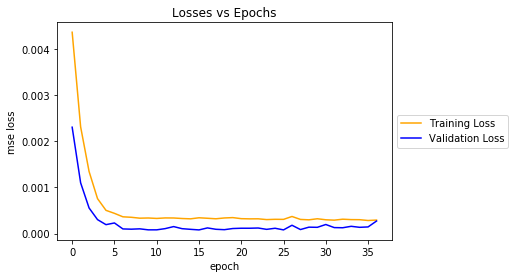

In [51]:
nb_epoch = 300
batch_size = 256

model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_valid, y_valid), callbacks=callbacks_list, shuffle=False)

### Load best weights

In [52]:
model.load_weights("Predict_Share_Prices_model_weights_best.hdf5")
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [53]:
X_test.shape

(1843, 5, 1)

In [54]:
# generate predictions for training
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

#### Plot - Predicted Values vs Actual

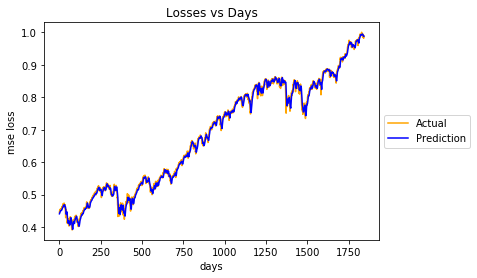

In [55]:
plt.plot(y_test, color='orange')
plt.plot(test_predict, color='blue')


plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### SP500 Dataset Training, Validation, and Testing Errors 

In [56]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

validation_error = model.evaluate(X_valid, y_valid, verbose=0)
print('validation error = ' + str(validation_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 5.13443490811e-05
validation error = 7.87252872915e-05
testing error = 0.000103909301219


In [57]:
training_error_SP500 = training_error
validation_error_SP500 = validation_error
testing_error_SP500 = testing_error

In [58]:
training_error_SP500, validation_error_SP500, testing_error_SP500

(5.1344349081129612e-05, 7.8725287291485106e-05, 0.00010390930121919108)

In [59]:
### Plot Predicted vs Actual Values

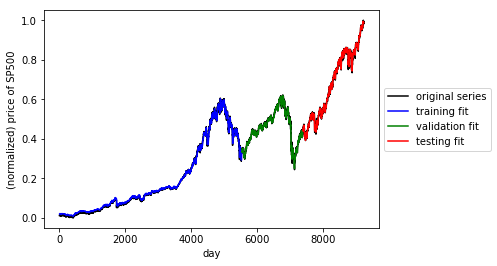

In [60]:
plt.plot(dataset,color = 'k')

plt.plot(np.arange(window_size,len(train_predict) + window_size,1),train_predict,color = 'b')

plt.plot(np.arange(len(train_predict),len(train_predict) + len(valid_predict),1),valid_predict,color = 'g')

plt.plot(np.arange(len(train_predict) + len(valid_predict),len(train_predict) + len(valid_predict) + len(test_predict),1),test_predict[:,0],color = 'r')

plt.xlabel('day')
plt.ylabel('(normalized) price of SP500')
plt.legend(['original series','training fit','validation fit', 'testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Predicting one value at a time

In [61]:
num = 1

x_test_initial = X_test_initial

preds = []

i = 0

while len(preds) + 1 < int(len(x_test_initial)/num):   
    a_input_test = x_test_initial[i * num : (i + 1) * num]
    a_input_test = np.asarray(np.reshape(a_input_test, (num, window_size, 1)))
    
    pred = model.predict(a_input_test)
    #print("pred=",pred)
    preds.append(pred)
    
    
    replace_nums = min(num, window_size)
    
    for j in range(replace_nums):
        for k in range(j+1):
            x_test_initial[(i + 1) * num + j][window_size - 1 - j + k] = pred[k]
        #print(x_test_initial[(i + 1) * num + j])    
    i += 1
    
y_preds=[]
for i in range(len(preds)):
    pred = preds[i]
    for j in range(len(pred)):
        y_preds.append(pred[j])    
        
test_data_len = min(len(y_preds), len(y_test))
testScore = mean_squared_error(y_preds[:test_data_len], y_test[:test_data_len])
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, np.sqrt(testScore))) 

Test Score: 0.00012001 MSE (0.01095495 RMSE)


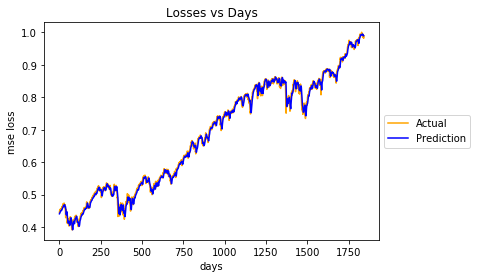

In [62]:
#plt.plot(y_preds)
#plt.plot(y_test) 

plt.plot(y_test, color='orange')
plt.plot(y_preds, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

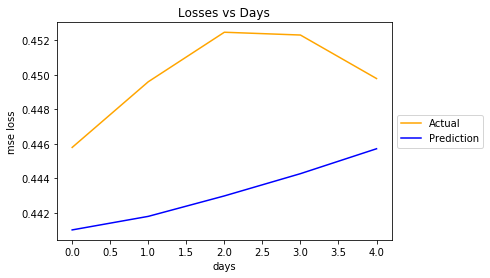

In [63]:
plt.plot(y_test[:5], color='orange')
plt.plot(y_preds[:5], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

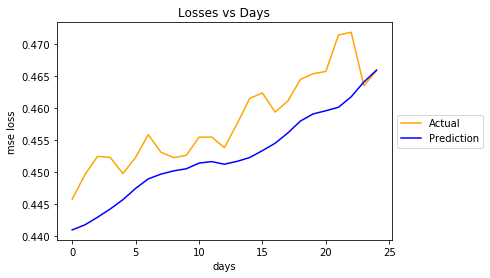

In [64]:
plt.plot(y_test[:25], color='orange')
plt.plot(y_preds[:25], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### Predicting 5 values at a time
#### Using predicted values for predicted future values

In [65]:
num = 5

x_test_initial = X_test_initial

preds = []

i = 0

while len(preds) + 1 < int(len(x_test_initial)/num):   
    a_input_test = x_test_initial[i * num : (i + 1) * num]
    a_input_test = np.asarray(np.reshape(a_input_test, (num, window_size, 1)))
    
    pred = model.predict(a_input_test)
    #print("pred=",pred)

    preds.append(pred)
    
    
    replace_nums = min(num, window_size)
    
    for j in range(replace_nums):
        for k in range(j+1):
            x_test_initial[(i + 1) * num + j][window_size - 1 - j + k] = pred[k] 
        #print(x_test_initial[(i + 1) * num + j])    
    i += 1

    
y_preds=[]
for i in range(len(preds)):
    pred = preds[i]
    for j in range(len(pred)):
        y_preds.append(pred[j])    
        
test_data_len = min(len(y_preds), len(y_test))
testScore = mean_squared_error(y_preds[:test_data_len], y_test[:test_data_len])
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, np.sqrt(testScore))) 

  

Test Score: 0.00023011 MSE (0.01516936 RMSE)


In [66]:
test_data_len = min(len(y_preds), len(y_test))
testScore = mean_squared_error(y_preds[:test_data_len], y_test[:test_data_len])
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, np.sqrt(testScore)))

Test Score: 0.00023011 MSE (0.01516936 RMSE)


In [67]:
len(y_test),len(y_preds)

(1843, 1835)

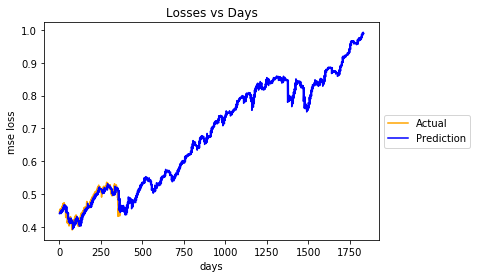

In [68]:
plt.plot(y_test[:len(preds)], color='orange')
plt.plot(y_preds, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

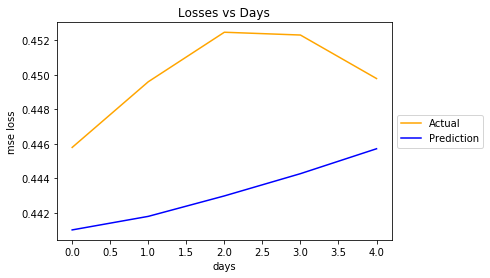

In [69]:
plt.plot(y_test[:5], color='orange')
plt.plot(y_preds[:5], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

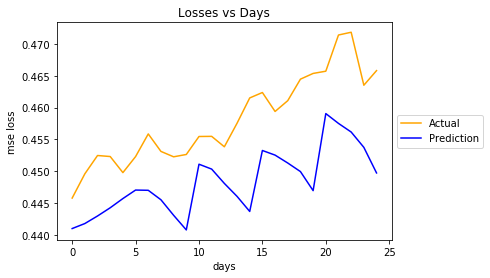

In [70]:
plt.plot(y_test[:25], color='orange')
plt.plot(y_preds[:25], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

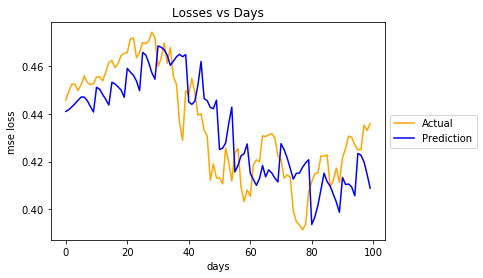

In [71]:
plt.plot(y_test[:100], color='orange')
plt.plot(y_preds[:100], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### Predicting 25 values at a time
#### Using predicted values for predicted future values

In [72]:
num = 25 

x_test_initial = X_test_initial

preds = []

i = 0

while len(preds) + 1 < int(len(x_test_initial)/num):   
    a_input_test = x_test_initial[i * num : (i + 1) * num]
    a_input_test = np.asarray(np.reshape(a_input_test, (num, window_size, 1)))
    
    pred = model.predict(a_input_test)

    preds.append(pred)
    
    #print(len(pred))
    #print("pred=",pred)
    
    index = int(num/window_size)
    #print("index = ",index)
    for j in range(index):
        for k in range(window_size):
            #print("j = ", j , " k = ",k)
            x_test_initial[(i + 1) * num + j][k] = pred[j * window_size + k]
        #print(x_test_initial[(i + 1) * num + j])
            
    i += 1
    
y_preds=[]
for i in range(len(preds)):
    pred = preds[i]
    for j in range(len(pred)):
        y_preds.append(pred[j])    
        
test_data_len = min(len(y_preds), len(y_test))
testScore = mean_squared_error(y_preds[:test_data_len], y_test[:test_data_len])
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, np.sqrt(testScore)))       

Test Score: 0.00033117 MSE (0.01819809 RMSE)


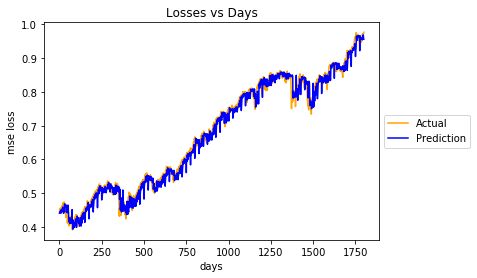

In [73]:
plt.plot(y_test[:len(y_preds)], color='orange')
plt.plot(y_preds, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

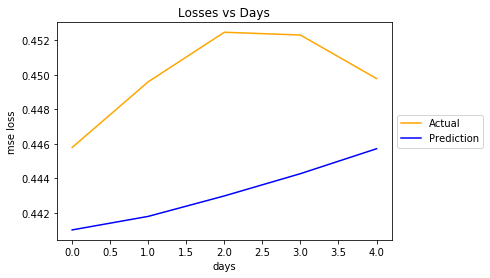

In [74]:
plt.plot(y_test[:5], color='orange')
plt.plot(y_preds[:5], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

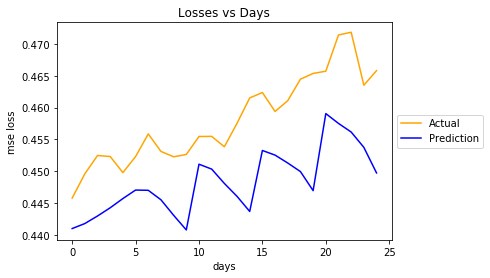

In [75]:
plt.plot(y_test[:25], color='orange')
plt.plot(y_preds[:25], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

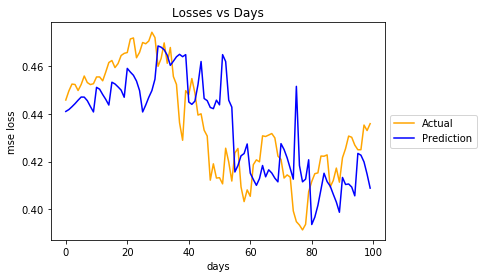

In [76]:
plt.plot(y_test[:100], color='orange')
plt.plot(y_preds[:100], color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### Above graphs show that if we use predicted values in future predictions, the predictions fall apart and correct results are only upto a few days. This happens because errors accumulate and trickles down to future values.

## Testing Model Robustness

### SP500 trained model is used to predict future values for other stocks

#### Results show that this model works quite well for all other stocks tested below.

### IBM

testing error = 0.000260660549434


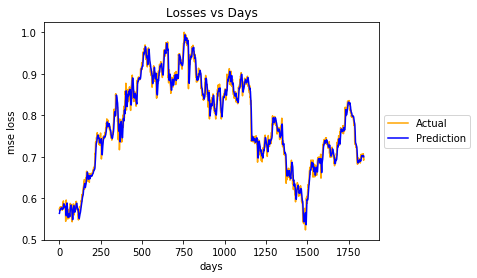

In [77]:
X_test_IBM_reshaped = np.asarray(np.reshape(X_test_IBM, (X_test_IBM.shape[0], window_size, 1)))
test_predict_IBM = model.predict(X_test_IBM_reshaped)

testing_error_IBM = model.evaluate(X_test_IBM_reshaped, y_test_IBM, verbose=0)
print('testing error = ' + str(testing_error_IBM))

plt.plot(y_test_IBM, color='orange')
plt.plot(test_predict_IBM, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
training_error_SP500, validation_error_SP500, testing_error_SP500, testing_error_IBM

(5.1344349081129612e-05,
 7.8725287291485106e-05,
 0.00010390930121919108,
 0.00026066054943374488)

### MSFT

testing error = 0.000184823298624


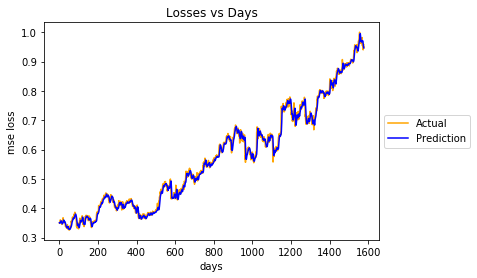

In [79]:
X_test_MSFT_reshaped = np.asarray(np.reshape(X_test_MSFT, (X_test_MSFT.shape[0], window_size, 1)))
test_predict_MSFT = model.predict(X_test_MSFT_reshaped)

testing_error = model.evaluate(X_test_MSFT_reshaped, y_test_MSFT, verbose=0)
print('testing error = ' + str(testing_error))

#plt.plot(test_predict_MSFT)
#plt.plot(y_test_MSFT)

plt.plot(y_test_MSFT, color='orange')
plt.plot(test_predict_MSFT, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### PFE

testing error = 0.000108408669474


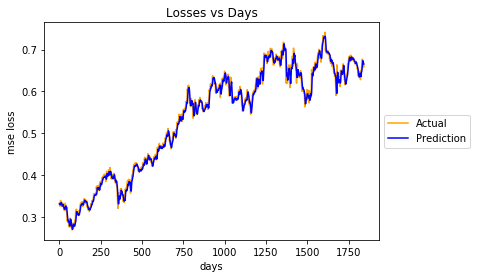

In [80]:
X_test_PFE_reshaped = np.asarray(np.reshape(X_test_PFE, (X_test_PFE.shape[0], window_size, 1)))
test_predict_PFE = model.predict(X_test_PFE_reshaped)

testing_error = model.evaluate(X_test_PFE_reshaped, y_test_PFE, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_PFE, color='orange')
plt.plot(test_predict_PFE, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### WMT

testing error = 0.000151255394945


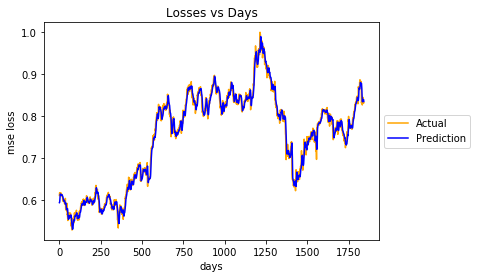

In [81]:
X_test_WMT_reshaped = np.asarray(np.reshape(X_test_WMT, (X_test_WMT.shape[0], window_size, 1)))
test_predict_WMT = model.predict(X_test_WMT_reshaped)

testing_error = model.evaluate(X_test_WMT_reshaped, y_test_WMT, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_WMT, color='orange')
plt.plot(test_predict_WMT, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### XOM

testing error = 0.000228371499655


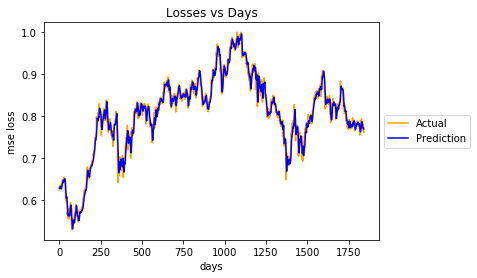

In [82]:
X_test_XOM_reshaped = np.asarray(np.reshape(X_test_XOM, (X_test_XOM.shape[0], window_size, 1)))
test_predict_XOM = model.predict(X_test_XOM_reshaped)

testing_error = model.evaluate(X_test_XOM_reshaped, y_test_XOM, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_XOM, color='orange')
plt.plot(test_predict_XOM, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### MYL

testing error = 0.000343096668766


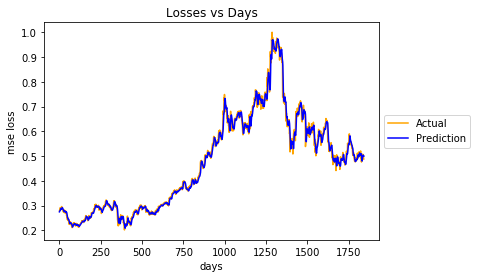

In [83]:
X_test_MYL_reshaped = np.asarray(np.reshape(X_test_MYL, (X_test_MYL.shape[0], window_size, 1)))
test_predict_MYL = model.predict(X_test_MYL_reshaped)

testing_error = model.evaluate(X_test_MYL_reshaped, y_test_MYL, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_MYL, color='orange')
plt.plot(test_predict_MYL, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### AAPL

testing error = 0.000212655547086


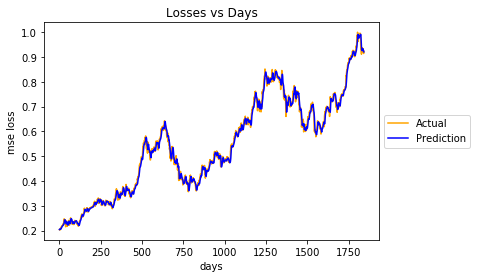

In [84]:
X_test_AAPL_reshaped = np.asarray(np.reshape(X_test_AAPL, (X_test_AAPL.shape[0], window_size, 1)))
test_predict_AAPL = model.predict(X_test_AAPL_reshaped)

testing_error = model.evaluate(X_test_AAPL_reshaped, y_test_AAPL, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_AAPL, color='orange')
plt.plot(test_predict_AAPL, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### GOOG

testing error = 0.000333827670244


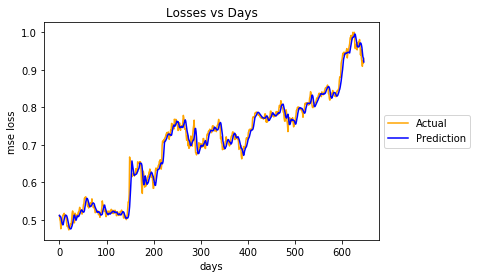

In [85]:
X_test_GOOG_reshaped = np.asarray(np.reshape(X_test_GOOG, (X_test_GOOG.shape[0], window_size, 1)))
test_predict_GOOG = model.predict(X_test_GOOG_reshaped)

testing_error = model.evaluate(X_test_GOOG_reshaped, y_test_GOOG, verbose=0)
print('testing error = ' + str(testing_error))

plt.plot(y_test_GOOG, color='orange')
plt.plot(test_predict_GOOG, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

# Benchmark Models

### Following benchmark models are considered
- Moving Averages
- Linear Regression
- KNN
- Support vector machines (RBF)
- Support vector machines (Poly)

#### Testing for these benchmarks show that only Linear Regression and Moving Averages are close to the performance obtained with Deep Learning LSTM model. Infact Linear Regression seems to give better results than Deep Learning model

# Moving averages

In [87]:
avg = np.mean(X_test,axis=1)

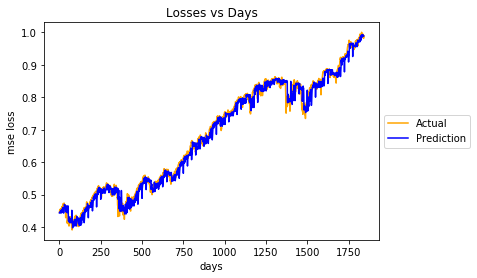

In [89]:
plt.plot(y_test, color='orange')
plt.plot(avg, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

In [90]:
testing_error_MovingAvg = mean_squared_error(avg, y_test)
print('Testing Error: %.8f MSE (%.8f RMSE)' % (testing_error_MovingAvg, np.sqrt(testing_error_MovingAvg)))

Testing Error: 0.00032865 MSE (0.01812868 RMSE)


# Linear Regression

In [92]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_initial, y_train)
#regr.fit(a, y_train)

# Make predictions using the testing set
y_preds = regr.predict(X_test_initial)

In [94]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[-0.00509697  0.04600088 -0.00160217 -0.04056057  1.00103732]]


In [95]:
testing_error_LinReg = mean_squared_error(y_preds, y_test)
print('Testing Error: %.8f MSE (%.8f RMSE)' % (testing_error_LinReg, np.sqrt(testing_error_LinReg)))

Testing Error: 0.00043885 MSE (0.02094873 RMSE)


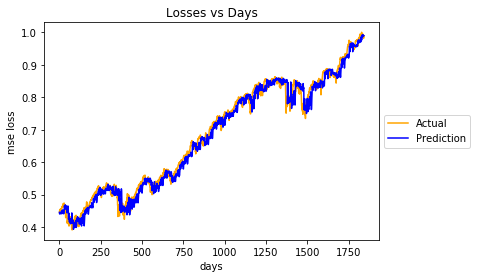

In [97]:
plt.plot(y_test, color='orange')
plt.plot(y_preds, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

# KNN

In [109]:
from sklearn.neighbors import KNeighborsRegressor

In [110]:
neigh = KNeighborsRegressor(n_neighbors=2)

In [111]:
neigh.fit(X_train_initial, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [112]:
y_pred = neigh.predict(X_test_initial)

In [113]:
testing_error_KNN = mean_squared_error(y_pred, y_test)
print('Testing Error: %.8f MSE (%.8f RMSE)' % (testing_error_KNN, np.sqrt(testing_error_KNN)))

Testing Error: 0.03221490 MSE (0.17948509 RMSE)


In [114]:
len(y_test),len(y_pred)

(1843, 1843)

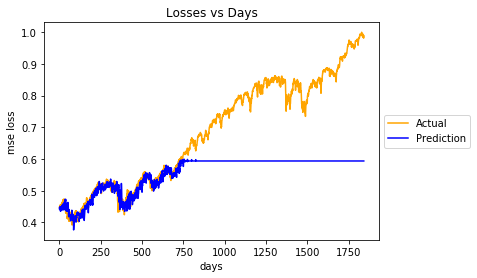

In [115]:
plt.plot(y_test, color='orange')
plt.plot(y_pred, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

## Support Vector Machine Model - RBF

In [117]:
from sklearn.svm import SVR

In [118]:
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)

In [163]:
y_train.shape

(5531, 1)

In [119]:
svr_rbf.fit(X_train_initial, y_train)

C:\Users\navneet\Anaconda3\envs\tensorflow-gpu-101\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [120]:
y_pred = svr_rbf.predict(X_test_initial)

In [121]:
testing_error_SVCrbf = mean_squared_error(y_pred, y_test)
print('Testing Error: %.8f MSE (%.8f RMSE)' % (testing_error_SVCrbf, np.sqrt(testing_error_SVCrbf)))

Testing Error: 0.02073039 MSE (0.14398052 RMSE)


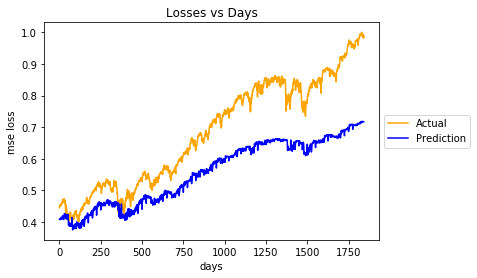

In [123]:
plt.plot(y_test, color='orange')
plt.plot(y_pred, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

## Support Vector Machine Model - Poly

In [124]:
svr_poly = SVR(kernel= 'poly', C= 1e3, degree= 1)

In [125]:
svr_poly.fit(X_train_initial, y_train)

C:\Users\navneet\Anaconda3\envs\tensorflow-gpu-101\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [126]:
y_pred = svr_poly.predict(X_test_initial)

In [127]:
testing_error_SVCpoly = mean_squared_error(y_pred, y_test)
print('Testing Error: %.8f MSE (%.8f RMSE)' % (testing_error_SVCpoly, np.sqrt(testing_error_SVCpoly)))

Testing Error: 0.01477115 MSE (0.12153664 RMSE)


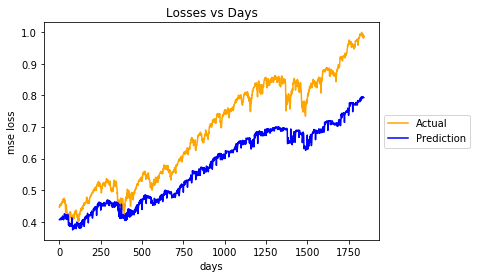

In [130]:
plt.plot(y_test, color='orange')
plt.plot(y_pred, color='blue')
plt.title("Losses vs Days")
plt.ylabel("mse loss")
plt.xlabel("days")
plt.legend(['Actual','Prediction'],loc='center left', bbox_to_anchor=(1, 0.5))

### Results for various Window Sizes and Batch Sizes

### Batch_size = 256

In [145]:

planets = [
    ['Window_Size', 'Test_Data_Size','SP500_Training_Error', 'SP500 Validation Error','SP500 Test Error', 'IBM Test Error' ,  'Moving Averages', 'LinearRegression' ,'KNN' ,  'SVC RBF', 'SVC Poly'],
    ['5', 1834,  '0.000051344337126', '0.0000787252756452', '0.000103909301219', '0.000260660549434', '0.000328648905233', '0.000438849293364', '0.0322148990166', '0.0207303912637', '0.0147711548446'], 
    ['10', 1834, '0.0000965952822298', '0.000222557387391', '0.00189797529227', '0.00268070314883', '0.000877105907589', '0.00351892198061', '0.0327944534789', '0.0253895686494', '0.0138963953446'],
    ['25', 1834, '0.0000847365657762', '0.000236428678015', '0.00162317017686', '0.00228520248074', '0.000501709363968', '0.00265200608575', '0.0371219664029', '0.0467874678058', '0.0089123926257'],
    ['50', 1834, '0.0000722316633343', '0.000167109420201', '0.000849359021461', '0.00126367325077', '0.000546926599796', '0.00141332856889', '0.0372982274899', '0.0713976792827', '0.0097539053037'],
    ['75', 1834, '0.000084983777966', '0.000137591368161',  '0.000442732383525', '0.000732548775446', '0.000710390033158', '0.000832935701555', '0.037727149025', '0.0825969726597', '0.0109342713402'],
    ['100', 1834,'0.0000610216291735', '0.000135159143898', '0.000353110310945', '0.000633140428762', '0.000894204285244', '0.000668359122954', '0.040125380317', '0.0918750870826', '0.0111881110828'],
    ['150', 1834,'0.0000753571949256', '0.000137474019121', '0.000222391018358', '0.000485783013124', '0.00137477029837', '0.000472771687058', '0.0469964593', '0.110754455582', '0.00992602156459']];
make_table(planets)

Window_Size,Test_Data_Size,SP500_Training_Error,SP500 Validation Error,SP500 Test Error,IBM Test Error,Moving Averages,LinearRegression,KNN,SVC RBF,SVC Poly
5,1834,0.000051344337126,0.0000787252756452,0.000103909301219,0.000260660549434,0.000328648905233,0.000438849293364,0.0322148990166,0.0207303912637,0.0147711548446
10,1834,0.0000965952822298,0.000222557387391,0.00189797529227,0.00268070314883,0.000877105907589,0.00351892198061,0.0327944534789,0.0253895686494,0.0138963953446
25,1834,0.0000847365657762,0.000236428678015,0.00162317017686,0.00228520248074,0.000501709363968,0.00265200608575,0.0371219664029,0.0467874678058,0.0089123926257
50,1834,0.0000722316633343,0.000167109420201,0.000849359021461,0.00126367325077,0.000546926599796,0.00141332856889,0.0372982274899,0.0713976792827,0.0097539053037
75,1834,0.000084983777966,0.000137591368161,0.000442732383525,0.000732548775446,0.000710390033158,0.000832935701555,0.037727149025,0.0825969726597,0.0109342713402
100,1834,0.0000610216291735,0.000135159143898,0.000353110310945,0.000633140428762,0.000894204285244,0.000668359122954,0.040125380317,0.0918750870826,0.0111881110828
150,1834,0.0000753571949256,0.000137474019121,0.000222391018358,0.000485783013124,0.00137477029837,0.000472771687058,0.0469964593,0.110754455582,0.00992602156459


In [146]:
TrainingError = (0.000051344337126,0.0000965952822298,0.0000847365657762, 0.0000722316633343,0.000084983777966, 0.0000610216291735, 0.0000753571949256)
ValiDationError = (0.0000787252756452, 0.000222557387391, 0.000236428678015, 0.000167109420201, 0.000137591368161, 0.000135159143898 , 0.000137474019121)
TestingError = (0.000103909301219, 0.00189797529227, 0.00162317017686, 0.000849359021461,  0.000442732383525, 0.000353110310945, 0.000222391018358 )
df = pd.DataFrame({"TrainingError":TrainingError, "ValidationError":ValiDationError,"TestingError":TestingError},index=(5,10,25,50,75,100, 150))

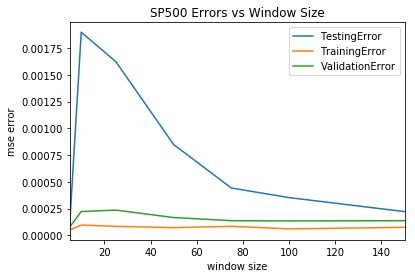

In [147]:
ax = df.plot(title="SP500 Errors vs Window Size")
ax.set_xlabel("window size")
ax.set_ylabel("mse error")

#### As per above data, window_size = 5 gives best performance for all 3 types of errors

### Batch_size = 512

In [148]:
#Batch_size = 512

planets = [
    ['Window_Size', 'Test_Data_Size','SP500_Training_Error', 'SP500 Validation Error','SP500 Test Error', 'IBM Test Error' ,  'Moving Averages', 'LinearRegression', 'SVC RBF', 'SVC Poly','KNN'],
    ['5',  1834, '0.000260719476114', '0.000091196570778', '0.000210013672127', '0.000441254033679', '0.000436260615935', '0.000742678531722', '0.0322421461053', '0.0195391580587', '0.0132543912368'], 
    ['50', 1834, '0.000055375614174', '0.000127494076335', '0.000883809936125', '0.00132370301675', '0.000544542412553', '0.00148063001301', '0.0372738879091', '0.0713705589457', '0.00975371850559'],
    ['75', 1834, '0.0000649366322045','0.000151496704863', '0.000180725808636', '0.000495337908947', '0.000693475798717', '0.000374284628277', '0.0377278644279', '0.0827787017944', '0.0107959306852'],
];
make_table(planets)

Window_Size,Test_Data_Size,SP500_Training_Error,SP500 Validation Error,SP500 Test Error,IBM Test Error,Moving Averages,LinearRegression,SVC RBF,SVC Poly,KNN
5,1834,0.000260719476114,0.000091196570778,0.000210013672127,0.000441254033679,0.000436260615935,0.000742678531722,0.0322421461053,0.0195391580587,0.0132543912368
50,1834,0.000055375614174,0.000127494076335,0.000883809936125,0.00132370301675,0.000544542412553,0.00148063001301,0.0372738879091,0.0713705589457,0.00975371850559
75,1834,0.0000649366322045,0.000151496704863,0.000180725808636,0.000495337908947,0.000693475798717,0.000374284628277,0.0377278644279,0.0827787017944,0.0107959306852


### Batch_size = 128

In [149]:
planets = [
    ['Window_Size', 'Test_Data_Size','SP500_Training_Error', 'SP500 Validation Error','SP500 Test Error', 'IBM Test Error' ,  'Moving Averages', 'LinearRegression', 'SVC RBF', 'SVC Poly','KNN'],
    ['5',  1834, '0.0000542481575105', '7.76013253873e-05', '0.000283995615181', '0.000485096523767', '0.000643976758497', '0.00111946466604', '0.0322126758034', '0.0225002921425', '0.0169704335245' ], 
    ['50', 1834, '0.0000883343537669', '0.00019307696998', '0.00196134649238', '0.00277898945788', '0.000569475055915', '0.0032869207067', '0.0373413117311', '0.0712499698552', '0.00995135431782'],
    ['75', 1834, '0.0000859053410981', '0.000216824562996', '0.0019206589265', '0.00271096587862', '0.000739599504352', '0.00311476805352', '0.0377278959955', '0.0824012900305', '0.0111328625875'],
];
make_table(planets)

Window_Size,Test_Data_Size,SP500_Training_Error,SP500 Validation Error,SP500 Test Error,IBM Test Error,Moving Averages,LinearRegression,SVC RBF,SVC Poly,KNN
5,1834,0.0000542481575105,7.76013253873e-05,0.000283995615181,0.000485096523767,0.000643976758497,0.00111946466604,0.0322126758034,0.0225002921425,0.0169704335245
50,1834,0.0000883343537669,0.00019307696998,0.00196134649238,0.00277898945788,0.000569475055915,0.0032869207067,0.0373413117311,0.0712499698552,0.00995135431782
75,1834,0.0000859053410981,0.000216824562996,0.0019206589265,0.00271096587862,0.000739599504352,0.00311476805352,0.0377278959955,0.0824012900305,0.0111328625875


In [150]:
# Window_size = 5
TestError_bs_128 = (0.000283995615181, 0.00196134649238, 0.0019206589265 )
TestError_bs_256 = (0.000103909301219, 0.000849359021461, 0.000353110310945)
TestError_bs_512 = (0.000210013672127, 0.000883809936125, 0.000180725808636 )

In [151]:
df_bs = pd.DataFrame({"TestError_bs_128": TestError_bs_128, "TestError_bs_256":TestError_bs_256, "TestError_bs_512":TestError_bs_512 }, index = (5,50,75))

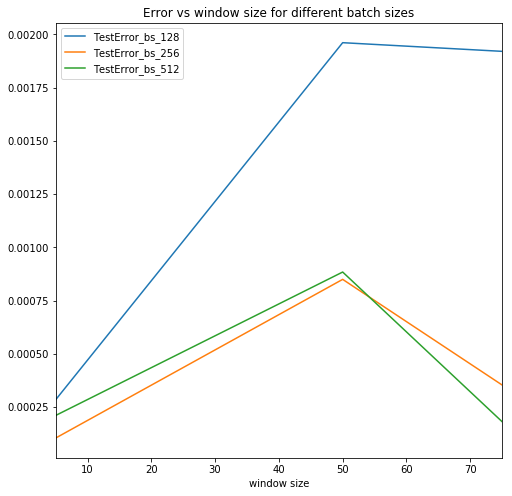

In [164]:
ax_bs = df_bs.plot(title = "Error vs window size for different batch sizes", figsize = (8,8))
ax_bs.set_xlabel("window size")
ax.set_ylabel("mse error")

#### As per above graph, Test Error is lowest for batch size=256 for window sizes below around 55 and Test Error is lowest for batch size = 512 and window sizes above 55.

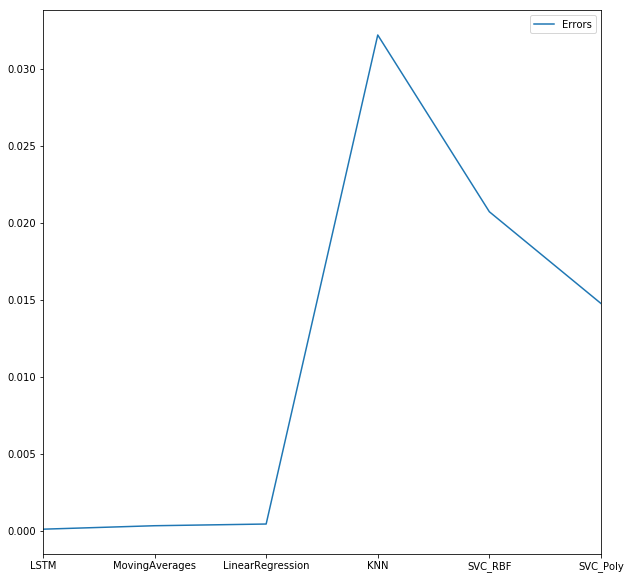

In [156]:
# Window Size = 5, Batch Size = 256
Errors = (0.000103909301219, 0.000328648905233, 0.000438849293364, 0.0322148990166, 0.0207303912637, 0.0147711548446)
index = ('LSTM', 'MovingAverages', 'LinearRegression', 'KNN', 'SVC_RBF', 'SVC_Poly' ) 

df_models = pd.DataFrame({"Errors": Errors}, index=index)
df_models.plot(figsize = (10,10))

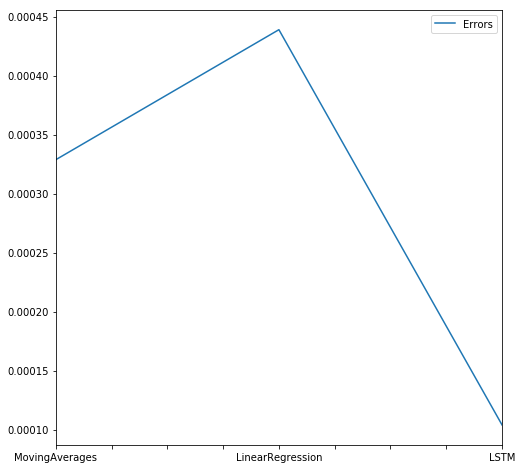

In [166]:
TestingErrors = ( 0.000328648905233, 0.000438849293364, 0.000103909301219)
index = ( 'MovingAverages', 'LinearRegression', 'LSTM') 

df_models = pd.DataFrame({"Errors": TestingErrors}, index=index)
df_models.plot(figsize=(8,8))

## Conclusion

#### As seen in above plots, Deep Learning LSTM Model with window_size = 5 and Batch_size = 256 gives best results